# 0. 패키지 임포트

In [3]:
# !pip install xgboost

  Using cached xgboost-1.5.2-py3-none-win_amd64.whl (106.6 MB)


In [4]:
#패키지 임포트
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.api import qqplot,add_constant
#선형모델 formula
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
#후진 제거법
from sklearn.feature_selection import RFE
#표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

matplotlib.rc('font',family = 'NanumGothic')
from scipy.stats import shapiro

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import os
import sklearn
os.environ['PATH'] +=os.pathsep+'/home/piai/anaconda3/lib/python3.8/site-packages/graphviz'

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.svm import SVC

# import warnings
# warnings.filterwarnings(action='ignore')

C:\Users\82106\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\82106\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\82106\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. 데이터 불러오기

In [5]:
customer_df = pd.read_csv('telco_customer.csv',encoding='utf-8') # 고객의 특징 데이터
# customer_df = customer_df[customer_df['AgeGroup']!='10대'] # 미국 기업의 데이터 특성상 10대 결혼한 케이스가 있음 정제 필요
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerId               5023 non-null   object 
 1   ContractID               5023 non-null   object 
 2   CustomerLTV              5023 non-null   int64  
 3   ChurnScore               5023 non-null   int64  
 4   SatisScore               5023 non-null   int64  
 5   ChurnLabel               5023 non-null   object 
 6   Gender                   5023 non-null   object 
 7   Age                      5023 non-null   int64  
 8   AgeGroup                 5023 non-null   object 
 9   Married                  5023 non-null   object 
 10  Dependents               5023 non-null   object 
 11  noDependents             5023 non-null   int64  
 12  Referrals                5023 non-null   object 
 13  noReferrals              5023 non-null   int64  
 14  Contract                

In [6]:
charge_df = pd.read_csv('telco_charge.csv',encoding = 'euc-kr') # 고객의 요금납부 데이터
charge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218710 entries, 0 to 218709
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerId  218710 non-null  object 
 1   ContractID  218710 non-null  object 
 2   ChargeDate  218710 non-null  object 
 3   ChargeAmt   218710 non-null  float64
dtypes: float64(1), object(3)
memory usage: 6.7+ MB


# 1-2. 결측치&이상치 제거

In [7]:
charge_df.isnull().sum()
# 이상치 없음

CustomerId    0
ContractID    0
ChargeDate    0
ChargeAmt     0
dtype: int64

In [8]:
customer_df.isnull().sum()
# EndDate, ChurnCategory, ChurnReason 공통적으로 4136개의 결측치가 존재함 

CustomerId                    0
ContractID                    0
CustomerLTV                   0
ChurnScore                    0
SatisScore                    0
ChurnLabel                    0
Gender                        0
Age                           0
AgeGroup                      0
Married                       0
Dependents                    0
noDependents                  0
Referrals                     0
noReferrals                   0
Contract                      0
PaperlessBilling              0
PaymentMethod                 0
OnlineSecurity                0
OnlineBackup                  0
DeviceProtection              0
TechSupport                   0
UnlimitedData                 0
AvgDownloadGB                 0
TotalRefund                   0
TotalExtraDataCharge          0
AvgLongDistanceCharge         0
TotalLongDistanceCharge       0
StartDate                     0
EndDate                    4125
ChurnCategory              4125
ChurnReason                4125
dtype: i

In [9]:
customer_df['EndDate'] # 이탈 날짜

0       01-01-2020
1       04-01-2020
2       06-01-2020
3       02-01-2020
4       02-01-2020
           ...    
5018           NaN
5019           NaN
5020           NaN
5021           NaN
5022           NaN
Name: EndDate, Length: 5023, dtype: object

In [10]:
customer_df['ChurnCategory'] # 이탈 이유 카테고리

0            Competitor
1       Dissatisfaction
2            Competitor
3            Competitor
4            Competitor
             ...       
5018                NaN
5019                NaN
5020                NaN
5021                NaN
5022                NaN
Name: ChurnCategory, Length: 5023, dtype: object

In [11]:
customer_df['ChurnReason'] # 이탈 이유

0       Competitor offered higher download speeds
1                         Product dissatisfaction
2                      Attitude of support person
3                   Competitor had better devices
4                    Competitor offered more data
                          ...                    
5018                                          NaN
5019                                          NaN
5020                                          NaN
5021                                          NaN
5022                                          NaN
Name: ChurnReason, Length: 5023, dtype: object

이탈에 관한 변수에 대한 NaN은 결측치로 보지 않음    
계약 지속 고객의 경우에 이탈 날짜, 이탈 이유는 없기때문에 결측치가 아닌 정상적인 데이터로 판단

# 1-3. 파생 변수 만들기

- AvgCharge : 평균 과금액(월)       
- TotalCharge : 총 과금액(총 기간)    
- TotalRevenue : 총 매출(TotalCharge + TotalExtraDataCharge + TotalLongDistanceCharge - TotalRefund)
- TenureMonths : 사용기간(월) 

### 1) AvgCharge

In [12]:
AvgCharge = pd.DataFrame(charge_df.groupby('CustomerId')['ChargeAmt'].mean()) # 한 고객의 총 과금액의 평균
AvgCharge

,ChargeAmt
CustomerId,
C-10001,73.877778
C-10002,99.715385
C-10003,114.732857
C-10004,87.972222
C-10005,93.982308
...,...
C-15120,88.189130
C-15121,57.250000
C-15122,89.604545


In [13]:
customer_df = pd.merge(customer_df, AvgCharge, how='left', on='CustomerId') # 기존 데이터프레임과 병합

In [14]:
customer_df['ChargeAmt'].isnull().sum() 
# 결측치 11명 확인 : 아직 과금액을 내지 않은 고객(한 달이 되지 않은 고객)

customer_df['ChargeAmt'].fillna(0,inplace=True)
print(customer_df.isnull().sum())

customer_df.rename(columns={'ChargeAmt':'AvgCharge'},inplace=True)

CustomerId                    0
ContractID                    0
CustomerLTV                   0
ChurnScore                    0
SatisScore                    0
ChurnLabel                    0
Gender                        0
Age                           0
AgeGroup                      0
Married                       0
Dependents                    0
noDependents                  0
Referrals                     0
noReferrals                   0
Contract                      0
PaperlessBilling              0
PaymentMethod                 0
OnlineSecurity                0
OnlineBackup                  0
DeviceProtection              0
TechSupport                   0
UnlimitedData                 0
AvgDownloadGB                 0
TotalRefund                   0
TotalExtraDataCharge          0
AvgLongDistanceCharge         0
TotalLongDistanceCharge       0
StartDate                     0
EndDate                    4125
ChurnCategory              4125
ChurnReason                4125
ChargeAm

### 2) TotalCharge

In [15]:
TotalCharge = pd.DataFrame(charge_df.groupby('CustomerId')['ChargeAmt'].sum()) # 한 고객의 총 과금액의 합계
customer_df = pd.merge(customer_df,TotalCharge,how='left', on='CustomerId')
customer_df.rename(columns ={'ChargeAmt' : 'TotalCharge'}, inplace = True)
customer_df

,CustomerId,ContractID,CustomerLTV,ChurnScore,SatisScore,ChurnLabel,Gender,Age,AgeGroup,Married,...,TotalRefund,TotalExtraDataCharge,AvgLongDistanceCharge,TotalLongDistanceCharge,StartDate,EndDate,ChurnCategory,ChurnReason,AvgCharge,TotalCharge
0,C-10710,G2QEWraUUx,2860,91,1,Yes,Female,62,60대,Yes,...,0.0,0,15.7,172.6,02-01-2019,01-01-2020,Competitor,Competitor offered higher download speeds,68.860000,688.60
1,C-10042,34kMTWHw29,5980,85,1,Yes,Female,78,70대,No,...,0.0,120,11.6,127.5,05-01-2019,04-01-2020,Dissatisfaction,Product dissatisfaction,102.063636,1122.70
2,C-10513,3eSje7ubR4,2044,70,1,Yes,Male,39,30대,Yes,...,0.0,0,21.6,237.4,07-01-2019,06-01-2020,Competitor,Attitude of support person,78.159091,859.75
3,C-10657,JkLnJ4unvX,2437,74,1,Yes,Male,77,70대,No,...,0.0,0,0.0,0.0,02-01-2019,02-01-2020,Competitor,Competitor had better devices,45.577273,501.35
4,C-10934,K8yDzLiZq3,4306,87,1,Yes,Male,57,50대,Yes,...,23.7,0,18.3,219.1,02-01-2019,02-01-2020,Competitor,Competitor offered more data,84.522727,929.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,C-14491,qFB3Ceg7eH,6011,46,5,No,Male,40,40대,Yes,...,0.0,0,4.2,298.8,01-01-2014,NaN,NaN,NaN,26.074648,1851.30
5019,C-14512,JuUWYz23oJ,6082,54,5,No,Male,62,60대,Yes,...,0.0,0,43.8,3156.5,01-01-2014,NaN,NaN,NaN,103.786620,7368.85
5020,C-14532,5QTAS8rbQQ,5425,59,5,No,Female,42,40대,No,...,0.0,0,24.2,1741.7,01-01-2014,NaN,NaN,NaN,115.538028,8203.20
5021,C-14611,ERiWyytih2,5832,53,5,No,Female,70,70대,Yes,...,0.0,80,18.2,1306.8,01-01-2014,NaN,NaN,NaN,109.719014,7790.05


In [16]:
customer_df['TotalCharge'].fillna(0,inplace=True)
customer_df['TotalCharge'].isnull().sum()

0

### 3) TotalRevenue

In [17]:
customer_df['TotalRevenue'] = customer_df["TotalCharge"] + customer_df["TotalExtraDataCharge"] + customer_df["TotalLongDistanceCharge"] - customer_df["TotalRefund"] # 과금액들의 합 - 총 환불액
customer_df

,CustomerId,ContractID,CustomerLTV,ChurnScore,SatisScore,ChurnLabel,Gender,Age,AgeGroup,Married,...,TotalExtraDataCharge,AvgLongDistanceCharge,TotalLongDistanceCharge,StartDate,EndDate,ChurnCategory,ChurnReason,AvgCharge,TotalCharge,TotalRevenue
0,C-10710,G2QEWraUUx,2860,91,1,Yes,Female,62,60대,Yes,...,0,15.7,172.6,02-01-2019,01-01-2020,Competitor,Competitor offered higher download speeds,68.860000,688.60,861.20
1,C-10042,34kMTWHw29,5980,85,1,Yes,Female,78,70대,No,...,120,11.6,127.5,05-01-2019,04-01-2020,Dissatisfaction,Product dissatisfaction,102.063636,1122.70,1370.20
2,C-10513,3eSje7ubR4,2044,70,1,Yes,Male,39,30대,Yes,...,0,21.6,237.4,07-01-2019,06-01-2020,Competitor,Attitude of support person,78.159091,859.75,1097.15
3,C-10657,JkLnJ4unvX,2437,74,1,Yes,Male,77,70대,No,...,0,0.0,0.0,02-01-2019,02-01-2020,Competitor,Competitor had better devices,45.577273,501.35,501.35
4,C-10934,K8yDzLiZq3,4306,87,1,Yes,Male,57,50대,Yes,...,0,18.3,219.1,02-01-2019,02-01-2020,Competitor,Competitor offered more data,84.522727,929.75,1125.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,C-14491,qFB3Ceg7eH,6011,46,5,No,Male,40,40대,Yes,...,0,4.2,298.8,01-01-2014,NaN,NaN,NaN,26.074648,1851.30,2150.10
5019,C-14512,JuUWYz23oJ,6082,54,5,No,Male,62,60대,Yes,...,0,43.8,3156.5,01-01-2014,NaN,NaN,NaN,103.786620,7368.85,10525.35
5020,C-14532,5QTAS8rbQQ,5425,59,5,No,Female,42,40대,No,...,0,24.2,1741.7,01-01-2014,NaN,NaN,NaN,115.538028,8203.20,9944.90
5021,C-14611,ERiWyytih2,5832,53,5,No,Female,70,70대,Yes,...,80,18.2,1306.8,01-01-2014,NaN,NaN,NaN,109.719014,7790.05,9176.85


### 4) TenureMonths

In [18]:
month = pd.DataFrame(charge_df.groupby('CustomerId')['CustomerId'].count()) # 한 고객의 count 수
month.rename(columns={'CustomerId':'count'},inplace=True)
# month
customer_df = pd.merge(customer_df,month,how='left', on='CustomerId')
customer_df.rename(columns={'count':'TenureMonths'},inplace=True)
customer_df

,CustomerId,ContractID,CustomerLTV,ChurnScore,SatisScore,ChurnLabel,Gender,Age,AgeGroup,Married,...,AvgLongDistanceCharge,TotalLongDistanceCharge,StartDate,EndDate,ChurnCategory,ChurnReason,AvgCharge,TotalCharge,TotalRevenue,TenureMonths
0,C-10710,G2QEWraUUx,2860,91,1,Yes,Female,62,60대,Yes,...,15.7,172.6,02-01-2019,01-01-2020,Competitor,Competitor offered higher download speeds,68.860000,688.60,861.20,10
1,C-10042,34kMTWHw29,5980,85,1,Yes,Female,78,70대,No,...,11.6,127.5,05-01-2019,04-01-2020,Dissatisfaction,Product dissatisfaction,102.063636,1122.70,1370.20,11
2,C-10513,3eSje7ubR4,2044,70,1,Yes,Male,39,30대,Yes,...,21.6,237.4,07-01-2019,06-01-2020,Competitor,Attitude of support person,78.159091,859.75,1097.15,11
3,C-10657,JkLnJ4unvX,2437,74,1,Yes,Male,77,70대,No,...,0.0,0.0,02-01-2019,02-01-2020,Competitor,Competitor had better devices,45.577273,501.35,501.35,11
4,C-10934,K8yDzLiZq3,4306,87,1,Yes,Male,57,50대,Yes,...,18.3,219.1,02-01-2019,02-01-2020,Competitor,Competitor offered more data,84.522727,929.75,1125.15,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,C-14491,qFB3Ceg7eH,6011,46,5,No,Male,40,40대,Yes,...,4.2,298.8,01-01-2014,NaN,NaN,NaN,26.074648,1851.30,2150.10,71
5019,C-14512,JuUWYz23oJ,6082,54,5,No,Male,62,60대,Yes,...,43.8,3156.5,01-01-2014,NaN,NaN,NaN,103.786620,7368.85,10525.35,71
5020,C-14532,5QTAS8rbQQ,5425,59,5,No,Female,42,40대,No,...,24.2,1741.7,01-01-2014,NaN,NaN,NaN,115.538028,8203.20,9944.90,71
5021,C-14611,ERiWyytih2,5832,53,5,No,Female,70,70대,Yes,...,18.2,1306.8,01-01-2014,NaN,NaN,NaN,109.719014,7790.05,9176.85,71


In [19]:
customer_df['TenureMonths'].isnull().sum() # 11개의 결측치
# 결측치는 아직 한 달이 채 안되었을 때 나타나는 값임
customer_df['TenureMonths'].fillna(0,inplace=True)
customer_df['TenureMonths'].isnull().sum() # 0개로 수정됌

0

# 2. 탐색적 분석

# 2-1. 현황 분석

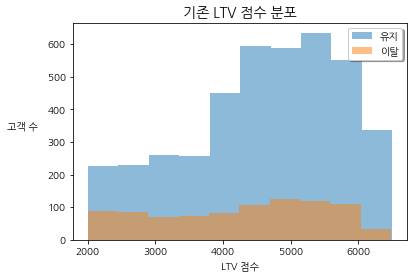

In [20]:
# 기존의 LTV 모델 점수 분포
# LTV(Life Time Value) : 고객 생애 가치로 사용자 1명당 서비스에서 이탈하기 전까지 지불하는 금액을 의미함
def fun_plot_hist(data, var):
    plt.hist(data[data["ChurnLabel"] == "No"][var], label = "유지", alpha = 0.5)  # 이탈 하지 않은 사람의 분포
    plt.hist(data[data["ChurnLabel"] == "Yes"][var], label = "이탈", alpha = 0.5) # 이탈 한 사람의 분포
    
fun_plot_hist(customer_df,'CustomerLTV')
plt.title("기존 LTV 점수 분포", fontsize=14)
plt.xlabel("LTV 점수", labelpad=5)
plt.ylabel("고객 수", rotation=0, labelpad=25)
plt.legend(shadow=True)

- LTV 점수에 상관없이 이탈률이 일정함
- 현재 모델은 핵심 고객을 분류하지 못하고 있음
- 고객의 특성에 맞춘 LTV 모델 개선으로 핵심고객 분류가 필요함

Text(0.5, 0, '년도')

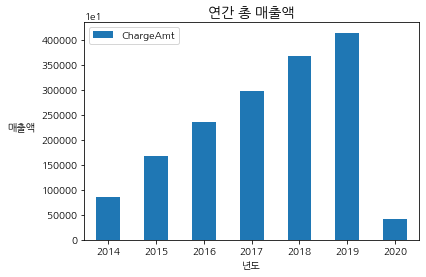

In [21]:
# 총 매출 매트릭스
charge_df['ChargeDate'] = pd.to_datetime(charge_df['ChargeDate']) # 과금일에서 년도만 뽑아내기 위해선 object가 아닌 datetime 형태여야함
charge_df['year'] = charge_df['ChargeDate'].dt.year # year 형태만 추출
annual_sales = charge_df.groupby('year').sum()
annual_sales.plot.bar(y='ChargeAmt')
plt.ticklabel_format(axis="y", style="sci", scilimits= (1,1)) # 10^m에서 10^n 범위밖으로 나갈 경우 과학적 표기법을 사용하기 때문에 변환
plt.xticks(rotation=0)
plt.title("연간 총 매출액", fontsize=14)
plt.ylabel("매출액", rotation=0, labelpad=20)
plt.xlabel("년도",labelpad=5)

- 총매출액이 증가하다가 2020년에 급격하게 하락하고 있음
- 핵심 고객 유지 및 신규 고객 유치를 통한 매출 증대 필요

In [22]:
# 이탈 이유
print(pd.DataFrame(customer_df['ChurnCategory'].value_counts()))
print(pd.DataFrame(customer_df['ChurnReason'].value_counts()))

                 ChurnCategory
Competitor                 394
Dissatisfaction            151
Attitude                   144
Price                      108
Other                      101
                                           ChurnReason
Competitor offered higher download speeds           97
Attitude of support person                          95
Competitor offered more data                        80
Don't know                                          74
Competitor made better offer                        61
Attitude of service provider                        60
Competitor had better devices                       56
Product dissatisfaction                             55
Service dissatisfaction                             46
Price too high                                      46
Lack of self-service on Website                     43
Network reliability                                 41
Extra data charges                                  35
Moved                                       

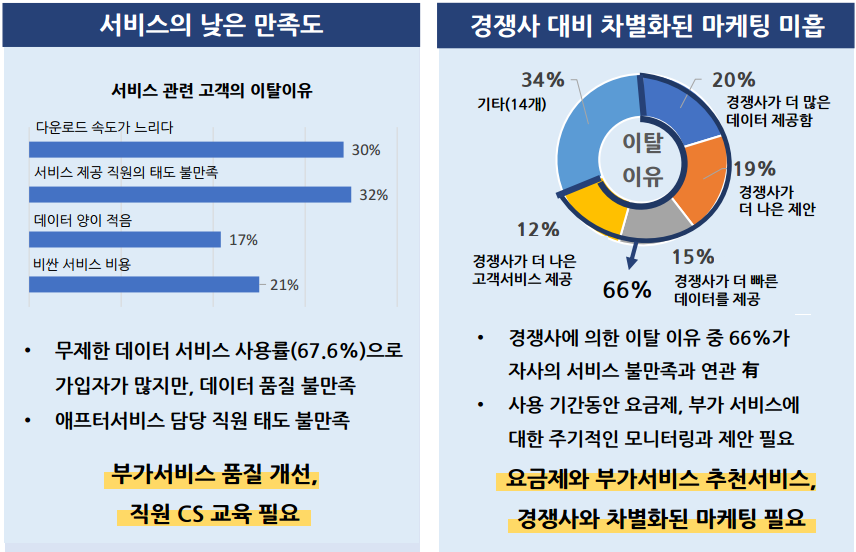

# 2-2. 이탈률 개선을 위한 분석
#### 고객 특성 : 결혼 여부, 부양자 수, 추천 횟수, 만족도 인사이트 도출

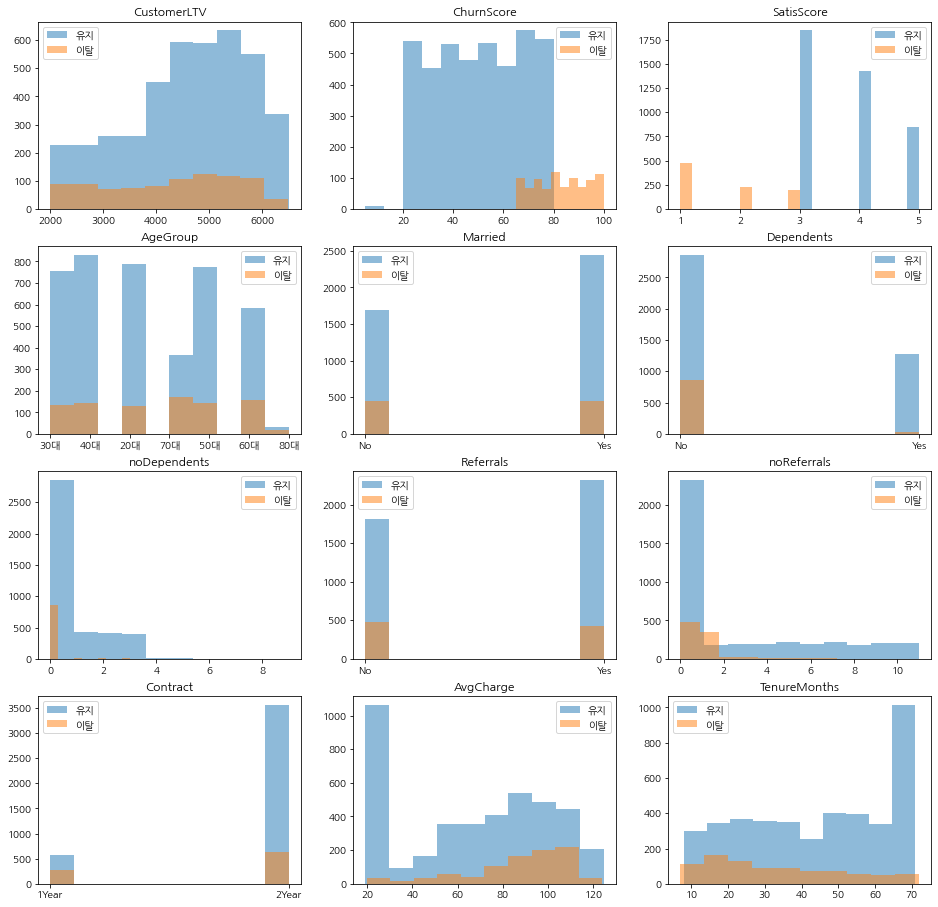

In [23]:
# 영향을 미치는 인자

influence_val = customer_df[['CustomerLTV','ChurnScore','SatisScore','AgeGroup',
                           'Married','Dependents','noDependents','Referrals','noReferrals',
                           'Contract','AvgCharge','TenureMonths']]

a = list(range(1,13))
fig, axes = plt.subplots(4,3,figsize=(16,20))

for var, i in zip(influence_val.columns,a):
    plt.subplot(5,3,i)
    plt.hist(customer_df[customer_df["ChurnLabel"] == "No"][var], label = "유지", alpha = 0.5) 
    plt.hist(customer_df[customer_df["ChurnLabel"] == "Yes"][var], label = "이탈", alpha = 0.5)
    plt.title(var)
    plt.legend()
plt.show()

- 만족도 점수 : 3점 미만 이탈, 3점 초과는 유지
- 결혼 여부 : 결혼한 고객일 수록 유지 확률이 높음
- 부양자 여부 : 부양자가 없을 때 이탈하고 있음
- 연령대 : 70~80대 많이 이탈 하고 있음. 적은 고객의 수이므로 해석에 유의해야함.
- 추천 여부 : 추천 수가 낮을 수록 이탈 확률이 높음
- 평균 다운로드 양 : 적을수록 이탈 확률이 높음
- 평균 요금 : 평균 요금이 높아질 수록 이탈 확률이 높음

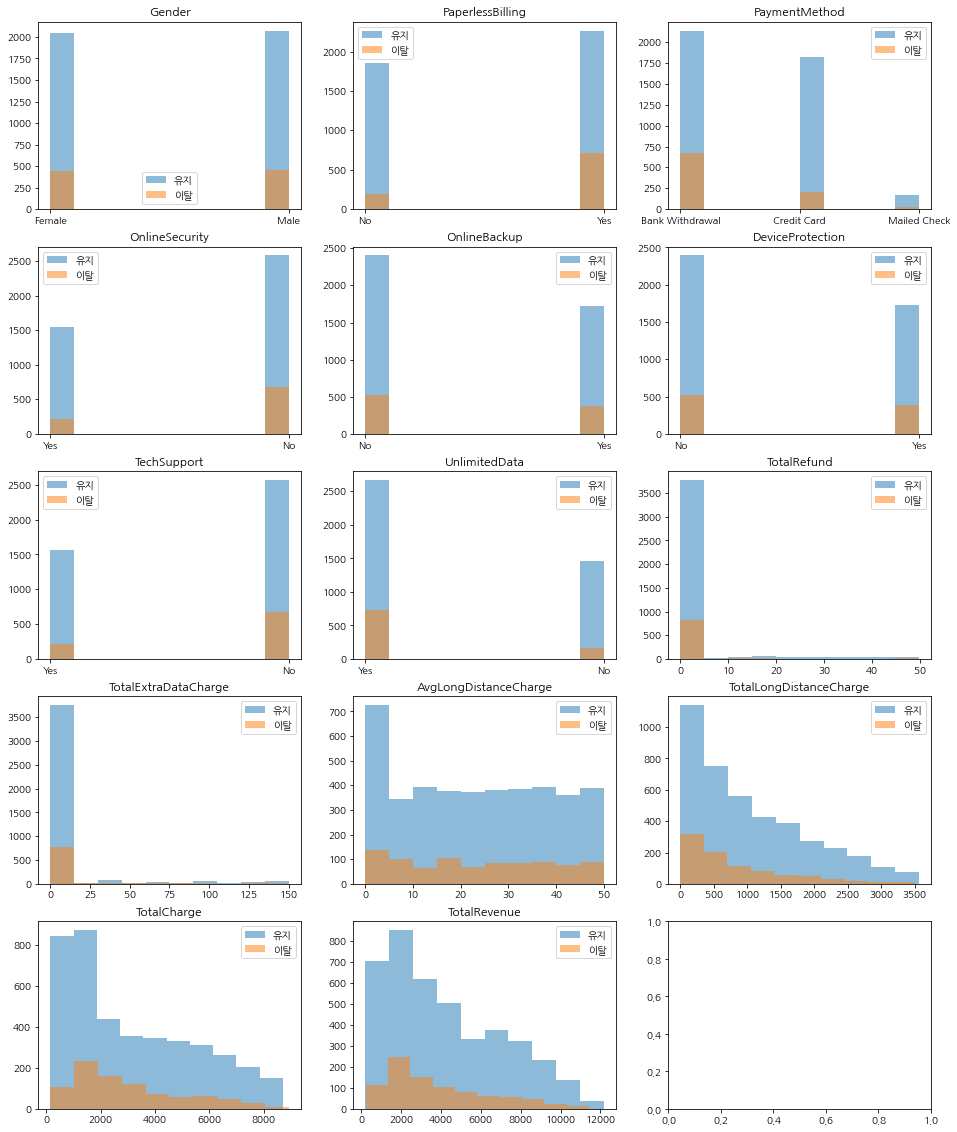

In [24]:
# 영향을 주지 못하는 인자

uninfluence_val = customer_df[['Gender', 'PaperlessBilling','PaymentMethod','OnlineSecurity',
                              'OnlineBackup','DeviceProtection','TechSupport','UnlimitedData',
                              'TotalRefund','TotalExtraDataCharge','AvgLongDistanceCharge',
                              'TotalLongDistanceCharge','TotalCharge','TotalRevenue']]

a = list(range(1,16))
fig, axes = plt.subplots(5,3,figsize=(16,20))

for var, i in zip(uninfluence_val.columns,a):
    plt.subplot(5,3,i)
    plt.hist(customer_df[customer_df["ChurnLabel"] == "No"][var], label = "유지", alpha = 0.5) 
    plt.hist(customer_df[customer_df["ChurnLabel"] == "Yes"][var], label = "이탈", alpha = 0.5)
    plt.title(var)
    plt.legend()
plt.show()

- 이탈한 고객과 이탈하지 않은 고객에 대한 비율의 차이가 거의 없음
- 즉, 이탈에 영향을 주지 않았다고 생각할 수 있음

# 2-3. 이탈 여부 변수에 대한 추가분석
#### Churnlabel 변수에 영향을 주는 중요 변수는 무엇일까?

In [25]:
churn_df = customer_df.drop(['CustomerId','ContractID','CustomerLTV','Gender','Age',
                            'PaperlessBilling','PaymentMethod','OnlineSecurity','OnlineBackup',
                            'DeviceProtection','TechSupport','UnlimitedData','AvgDownloadGB',
                            'TotalRefund','TotalExtraDataCharge','AvgLongDistanceCharge',
                            'TotalLongDistanceCharge','StartDate','EndDate','ChurnCategory','ChurnReason',
                            'TotalCharge','TotalRevenue'],axis=1) # 의미 없는 변수(명목변수, 서비스 여부) 제거 후 분석
churn_df.head()

,ChurnScore,SatisScore,ChurnLabel,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,Contract,AvgCharge,TenureMonths
0,91,1,Yes,60대,Yes,No,0,Yes,1,1Year,68.860000,10
1,85,1,Yes,70대,No,Yes,1,No,0,1Year,102.063636,11
2,70,1,Yes,30대,Yes,No,0,Yes,1,1Year,78.159091,11
3,74,1,Yes,70대,No,No,0,No,0,1Year,45.577273,11
4,87,1,Yes,50대,Yes,No,0,Yes,3,1Year,84.522727,11


In [26]:
# 더미화 : 이후 회귀분석에 사용하기 위해서 범주형 변수를 연속형 변수로 변환 
churn_df.replace({'Yes':1, 'No':0},inplace=True)
churn_df.replace({'Male':1, 'Female':0}, inplace=True)
churn_df.replace({'2Year':1, '1Year':0}, inplace=True)

churn_df['TenureMonths'].fillna(0,inplace=True) # 1개월 미만 사용자인 경우 0 입력

In [27]:
churn_y = churn_df[['ChurnLabel']] # y 지정
churn_x = churn_df.drop('ChurnLabel', axis=1) # x 지정
# churn_x.info()
churn_dummies_x = pd.get_dummies(churn_x)
# churn_dummies_x.info()

In [28]:
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(churn_dummies_x,churn_y,
                                                            test_size = 0.3, random_state=1234)

print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))

train data X size : (3516, 17)
train data Y size : (3516, 1)
test data X size : (1507, 17)
test data Y size : (1507, 1)


In [29]:
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(df_train_x,df_train_y)
print('Accuracy on training set : {:.3f}'.format(tree.score(df_train_x,df_train_y)))
print('Accuracy on test set : {:.3f}'.format(tree.score(df_test_x,df_test_y)))
# train 100%로 과대적합

Accuracy on training set : 1.000
Accuracy on test set : 0.977


In [30]:
# 하이퍼 파라미터 조정 : 트리의 최대 깊이
# 갚이 클수록 모델의 복잡도가 올라감

train_score = []; test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(random_state=1234
                                , max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth["TrainScore"]= train_score
df_score_depth["TestScore"]= test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.960,0.965
1,2,0.982,0.985
2,3,0.982,0.985
3,4,0.982,0.985
4,5,0.982,0.985
5,6,0.982,0.985
6,7,0.982,0.985
7,8,0.984,0.985
8,9,0.985,0.977
9,10,0.989,0.981


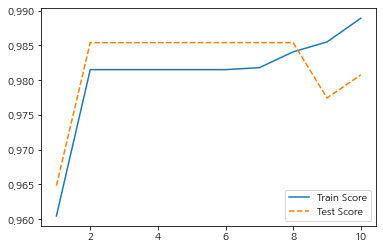

In [31]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.legend()
# train/test 데이터의 성능 변화를 고려하여 depth를 2로 결정

In [32]:
# 하이퍼 파라미터 조정 : 자식 노드를 분할하는데 필요한 최소 샘플 수

train_score = []; test_score = []

para_split = [n_split *20 for n_split in range(1,11)]

for v_min_split in para_split:
    tree = DecisionTreeClassifier(random_state=1234
                                , max_depth=2, min_samples_split=v_min_split)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSampleSplit'] = para_split
df_score_split["TrainScore"]= train_score
df_score_split["TestScore"]= test_score
df_score_split.round(3)

,MinSampleSplit,TrainScore,TestScore
0,20,0.982,0.985
1,40,0.982,0.985
2,60,0.982,0.985
3,80,0.982,0.985
4,100,0.982,0.985
5,120,0.982,0.985
6,140,0.982,0.985
7,160,0.982,0.985
8,180,0.982,0.985
9,200,0.982,0.985


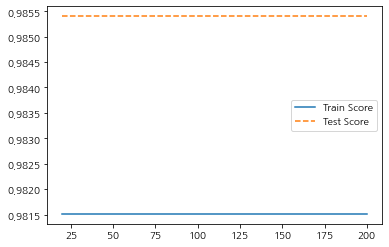

In [33]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

# 분리노드의 최소자료 수는 커질수록 과적합이 방지되는 경향이 있으나 test score가 동일한 수준을 보이므로 20으로 설정

In [34]:
# 하이퍼 파라미터 조정 : 리프 노드에 있어야할 최소 샘플 수
train_score = []; test_score = []

para_leaf = [n_leaf *4 for n_leaf in range(1,11)]

for v_min_leaf in para_leaf:
    tree = DecisionTreeClassifier(random_state=1234
                                , max_depth=2, min_samples_leaf=v_min_leaf, min_samples_split=200)#
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampleLeaf'] = para_leaf
df_score_leaf["TrainScore"]= train_score
df_score_leaf["TestScore"]= test_score
df_score_leaf.round(3)

# 잎사귀 노드의 최소 자료 수는 커질 수록 과적합이 방지되므로 test score가 낮아지지 않는 선에서 가장 큰 값을 선택 
# 전반적으로 같기 때문에 적당한 값으로 선택 

,MinSampleLeaf,TrainScore,TestScore
0,4,0.982,0.985
1,8,0.982,0.985
2,12,0.982,0.985
3,16,0.982,0.985
4,20,0.982,0.985
5,24,0.982,0.985
6,28,0.982,0.985
7,32,0.982,0.985
8,36,0.982,0.985
9,40,0.982,0.985


In [35]:
churn_dt_result = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=16, min_samples_split=20)
churn_dt_result.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=16, min_samples_split=20,
                       random_state=1234)

In [36]:
# 최종 모델 시각화 (생략)
# import graphviz

# v_feature_name = df_test_x.columns
# export_graphviz(result, out_file = 'result_dt.dot', class_names = ["STAY",'OUT'],
#                feature_names = v_feature_name, impurity=True,filled=True)

# with open('tree_final.dot')as f:
#     dot_grape = f.read()
# display(graphviz.Source(dot_grape))

In [37]:
y_pred = churn_dt_result.predict(df_test_x)
print('Accuracy: {:.3f}'.format(churn_dt_result.score(df_test_x,df_test_y)))
print('Confusion matrix: \n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy: 0.985
Confusion matrix: 
[[1238    0]
 [  22  247]]


In [38]:
a=1238/(1238+22) # recall
b=1238/(1238+0) # precision
print("recall : {:.3f}".format(a))
print("precision : {:.3f}".format(b))

c=2*(a*b)/(a+b) #F1 score
print("F1 score : {:.3f}".format(c))

recall : 0.983
precision : 1.000
F1 score : 0.991


In [39]:
# GridSearch를 이용해서 bestparameter 찾기 (참고용)
estimator = DecisionTreeClassifier()

param_grid = {"max_depth" : para_depth,
             'min_samples_leaf':para_leaf,
             'min_samples_split':para_split}
grid_tree = GridSearchCV(estimator, param_grid, scoring = 'accuracy',n_jobs=-1)

grid_tree.fit(df_train_x,df_train_y)
print('best estimator model :\n{}'.format(grid_tree.best_estimator_))
print('\n best parameter : \n{}'.format(grid_tree.best_params_))
print('\nbest score :\n{}'.format(grid_tree.best_score_.round(3)))

best estimator model :
DecisionTreeClassifier(max_depth=7, min_samples_leaf=12, min_samples_split=20)

 best parameter : 
{'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 20}

best score :
0.982


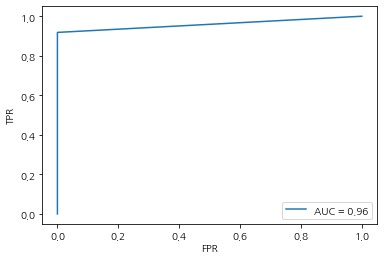

In [40]:
from sklearn.metrics import f1_score, roc_curve, auc
model_f1_score=[]
model_auc=[]
y_pred = churn_dt_result.predict(df_test_x)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr,tpr)

model_auc.append(roc_auc)
plt.plot(fpr,tpr,label= "AUC = %0.2f"%roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.show()

In [41]:
# feature importance 확인
v_feature_name = df_test_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"]=churn_dt_result.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
1,SatisScore,0.843
0,ChurnScore,0.157
9,TenureMonths,0.000
15,AgeGroup_70대,0.000
14,AgeGroup_60대,0.000
13,AgeGroup_50대,0.000
12,AgeGroup_40대,0.000
11,AgeGroup_30대,0.000
10,AgeGroup_20대,0.000
8,AvgCharge,0.000


- 만족도 점수가 3점 미만은 이탈, 3점 초과는 유지로 극단적인 결과를 보였음
- 이탈 여부 변수에 대해 가장 큰 영향을 미칠 수밖에 없음
- 그렇다면 만족도에 영향을 주는 변수는 무엇일까?

# 2-4. 만족도 변수에 대한  추가 분석
#### 이탈에 큰 영향을 미치는 변수는 만족도! 그렇다면 만족도에 영향을 주는 중요 변수는 무엇일까?

In [42]:
satis_df = customer_df.drop(['CustomerId','ContractID','CustomerLTV','ChurnScore',
                            'ChurnLabel','Gender','Age','PaymentMethod','OnlineBackup',
                            'StartDate','EndDate','ChurnCategory','ChurnReason'],axis=1) # 의미 없는 변수(명목변수, 서비스 여부) 제거 후 분석

In [43]:
# 더미화 : 이후 회귀분석에 사용하기 위해서 범주형 변수를 연속형 변수로 변환 
satis_df.replace({'Yes':1, 'No':0},inplace=True)
satis_df.replace({'Male':1, 'Female':0}, inplace=True)
satis_df.replace({'2Year':1, '1Year':0}, inplace=True)

satis_df['TenureMonths'].fillna(0,inplace=True)
 # 1개월 미만 사용자인 경우 0 입력

In [44]:
satis_y = satis_df[['SatisScore']]
satis_x = satis_df.drop('SatisScore', axis=1)

satis_dummies_x = pd.get_dummies(satis_x)

df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(satis_dummies_x,
                                                             satis_y,test_size=0.4,
                                                             random_state=1234)

In [45]:
#모델 생성 - 기본옵션으로 모델 생성
satisc_rf_uncustomized = RandomForestRegressor(random_state=1234)
satisc_rf_uncustomized.fit(df_train_x, df_train_y)
#train 데이터 설명력
print('Score on training set: {:.3f}'.format(satisc_rf_uncustomized.score(df_train_x, df_train_y)))
#test 데이터 설명력
print('Score on test set: {:.3f}'.format(satisc_rf_uncustomized.score(df_test_x, df_test_y)))

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1112867775.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  satisc_rf_uncustomized.fit(df_train_x, df_train_y)


Score on training set: 0.883
Score on test set: 0.134


In [46]:
# 하이퍼  파라미터 조정 : n_estimators 트리 수 변경에 따른 모델 성능
train_score = []; test_score = []

#n_estimatos : 트리 수 변경 (1~400)
# 무작정 트리 갯수를 늘리면 성능이 좋아지는 것 대비 시간이 과다 소요 가능성 있음
para_n_tree = [n_tree * 1 for n_tree in range(1, 400, 100)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators']=para_n_tree
df_score_n['TrainScore']=train_score
df_score_n['TestScore']=test_score

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/2460562730.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/2460562730.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/2460562730.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/2460562730.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(

<function matplotlib.pyplot.legend(*args, **kwargs)>

C:\Users\82106\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82106\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


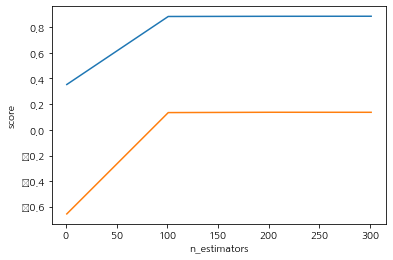

In [47]:
plt.plot(para_n_tree, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend

In [48]:
# 하이퍼 파라미터 조정 : 리프 노드가 되기 위해 필요한 최소한의 샘플 데이터 수
# 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
n_estimators = 150

#train 및 test 설명력 결과 저장
train_score = []; test_score = []
para_leaf=[n_leaf * 1 for n_leaf in range(1, 110, 10)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators = 150, random_state = 1234,
                              min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['min_samples_leaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1416536449.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1416536449.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1416536449.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1416536449.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(

In [49]:
#모델 설명력 확인
df_score_leaf.round(3)

,min_samples_leaf,TrainScore,TestScore
0,1,0.884,0.135
1,11,0.455,0.158
2,21,0.346,0.167
3,31,0.300,0.168
4,41,0.274,0.170
5,51,0.255,0.171
6,61,0.243,0.170
7,71,0.233,0.169
8,81,0.224,0.169
9,91,0.216,0.169


<function matplotlib.pyplot.legend(*args, **kwargs)>

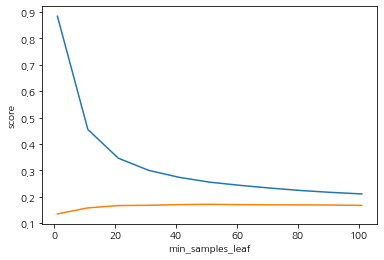

In [50]:
plt.plot(para_leaf, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min_samples_leaf')
plt.legend

In [51]:
min_samples_leaf = 81
# train, test의 차이가 크지 않으면서 높은 지점으로 대략 81지정

train_score = []; test_score = []

# 하이퍼 파라미터 조정 : 노드를 분할하기 위한 최소한의 샘플 데이터의 수
# 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가
para_split=[n_split * 1 for n_split in range(1, 330, 30)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(n_estimators = 150, random_state = 1234,
                              min_samples_leaf=81, min_samples_split=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_split = pd.DataFrame()
df_score_split['min_samples_split']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/828282674.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/828282674.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/828282674.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/828282674.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_t

In [52]:
#모델 설명력 확인
df_score_split.round(3)

,min_samples_split,TrainScore,TestScore
0,1,0.224,0.169
1,31,0.224,0.169
2,61,0.224,0.169
3,91,0.224,0.169
4,121,0.224,0.169
5,151,0.224,0.169
6,181,0.224,0.169
7,211,0.224,0.169
8,241,0.224,0.169
9,271,0.224,0.169


<function matplotlib.pyplot.legend(*args, **kwargs)>

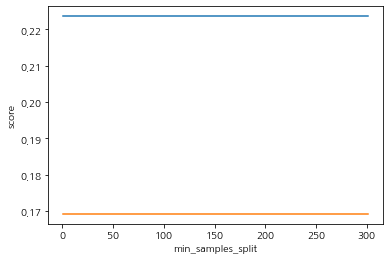

In [53]:
plt.plot(para_split, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min_samples_split')
plt.legend

In [54]:
# 하이퍼 파라미터 조정 : 트리의 최대 깊이 조정
# 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요
train_score = []; test_score = []

para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth :
    rf = RandomForestRegressor(n_estimators = 150, random_state = 1234,
                              min_samples_leaf=81,
                              max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/3070909924.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/3070909924.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/3070909924.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_train_x, df_train_y)
C:\Users\82106\AppData\Local\Temp/ipykernel_14112/3070909924.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(

In [55]:
#모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.066,0.070
1,2,0.108,0.100
2,3,0.153,0.134
3,4,0.188,0.156
4,5,0.210,0.167
5,6,0.220,0.169
6,7,0.223,0.169
7,8,0.224,0.169
8,9,0.224,0.169
9,10,0.224,0.169


<function matplotlib.pyplot.legend(*args, **kwargs)>

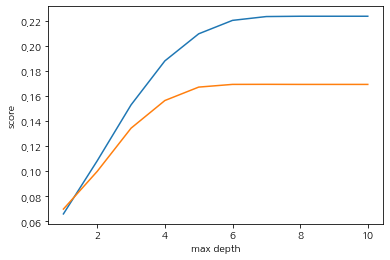

In [56]:
plt.plot(para_depth, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('max depth')
plt.legend

In [57]:
#최종 모델 생성
rf_final=RandomForestRegressor(random_state=1234, n_estimators=150, min_samples_leaf=81,
                               max_depth=6)
rf_final.fit(df_train_x, df_train_y)
print('Score on training sef: {:.3f}'.format(rf_final.score(df_train_x, df_train_y))) # train 설명력
print('Score on test set: {:.3f}'.format(rf_final.score(df_test_x, df_test_y))) # test 설명력

C:\Users\82106\AppData\Local\Temp/ipykernel_14112/1592707993.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final.fit(df_train_x, df_train_y)


Score on training sef: 0.220
Score on test set: 0.169


In [58]:
v_feature_name=df_train_x.columns

# 설명변수의 중요도
df_importance = pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
16,AvgCharge,0.375
4,noReferrals,0.200
19,TenureMonths,0.118
7,OnlineSecurity,0.099
11,AvgDownloadGB,0.034
15,TotalLongDistanceCharge,0.029
9,TechSupport,0.024
3,Referrals,0.023
18,TotalRevenue,0.020
17,TotalCharge,0.020


- 만족도에는 평균 과금액이 가장 큰 영향을 미치는 것으로 보임

### 이탈률 개선을 위한 분석 2
**부가서비스 : 5가지 서비스에 따른 인사이트 도출    
연관분석을 통해 서비스 간의 연관성 분석**

In [59]:
# !pip install mlxtend
# 연관분석 패키지 임포트
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [60]:
service = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','UnlimitedData']

for i in service:
    customer_df[i] = customer_df[i].map(lambda x : 0 if x == "No" else 1) # lambda를 이용해 수치형으로 변환 : Yes/No > 1/0

# 연관분석 패키지에 맞는 데이터 구조 만들기
link_df = customer_df[["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","UnlimitedData"]]

In [61]:
v_min_sup=0.01
link_result = apriori(link_df, min_support=v_min_sup, use_colnames=True)
link_result.round(3)

,support,itemsets
0,0.350,(OnlineSecurity)
1,0.417,(OnlineBackup)
2,0.421,(DeviceProtection)
3,0.354,(TechSupport)
4,0.677,(UnlimitedData)
5,0.208,"(OnlineSecurity, OnlineBackup)"
6,0.207,"(OnlineSecurity, DeviceProtection)"
7,0.202,"(TechSupport, OnlineSecurity)"
8,0.304,"(OnlineSecurity, UnlimitedData)"
9,0.246,"(OnlineBackup, DeviceProtection)"


    P(기술보호)=0.420, P(기술보호∩무제한데이터)=0.365     
    P(기술지원)=0.354, P(기술지원∩무제한데이터)=0.304    
    대부분 무제한데이터를 사용하고 3명 중 1명 고객정도는 추가 서비스를 하나 더 선택함

#### 많은 고객이 사용하는 '무제한 데이터'에 대한 추가 분석

In [91]:
def unlimited_plot_hist(data, var):
    plt.hist(data[data["UnlimitedData"] == 1][var], label = "가입", alpha = 0.5, align='left') # 1=Yes
    plt.hist(data[data["UnlimitedData"] == 0][var], label = "미가입", alpha = 0.5, align='left') # 0=No

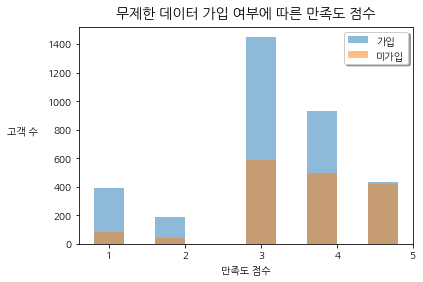

In [94]:
unlimited_plot_hist(customer_df,'SatisScore')
plt.legend()
plt.title("무제한 데이터 가입 여부에 따른 만족도 점수", fontsize=14, pad=10)
plt.xlabel("만족도 점수", labelpad=5)
plt.xticks(np.arange(1,5.5,1))
plt.ylabel("고객 수", rotation=0, labelpad=25)
plt.legend(shadow=True)
#무제한 데이터에 가입한 고객의 만족도가 낮음

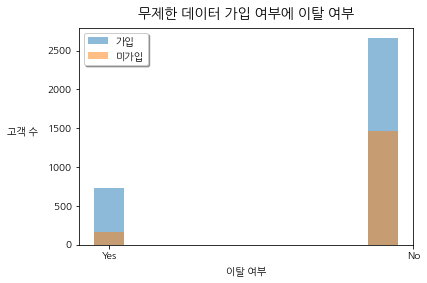

In [106]:
unlimited_plot_hist(customer_df,'ChurnLabel')
plt.title("무제한 데이터 가입 여부에 이탈 여부", fontsize=14, pad=10)
plt.xlabel('이탈 여부', labelpad=5)
plt.ylabel("고객 수", rotation=0, labelpad=25)
plt.legend(shadow=True)
#무제한 데이터 고객 중 이탈률 22% (전체 이탈률:17.5%)

- 무제한 데이터 고객 중 이탈률 22% (전체 이탈률:17.5%)
- 서비스 가입률은 높은 편(67.6%)이지만 만족도가 낮아 이탈자 발생 → 서비스 품질 문제 파악

### 이탈률 개선을 위한 분석 3
#### 사용패턴 : 평균 과금액, 다운로드양, 계약기간에 따른 인사이트 도출

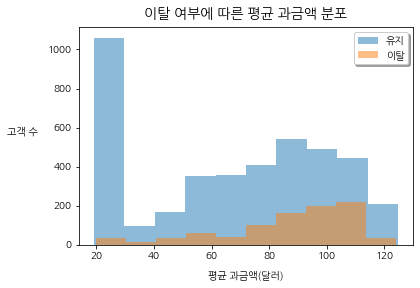

In [105]:
# 평균 과금액 
fun_plot_hist(customer_df,'AvgCharge')
plt.title("이탈 여부에 따른 평균 과금액 분포", fontsize=14, pad=10)
plt.xlabel('평균 과금액(달러)',labelpad=10)
plt.ylabel("고객 수", rotation=0, labelpad=25)
plt.legend(shadow=True)

- 평균 과금액이 높을수록 이탈자 수가 많음 → 서비스 품질에 비해 비싼 비용에 부담을 느낀다는 것을 알 수 있음    
- 서비스 품질 관리와 요금제에 대한 개선이 필요함

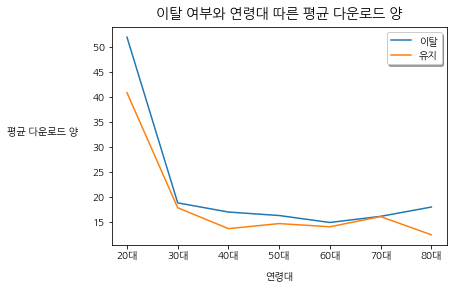

In [110]:
# 다운로드양
customer_df[customer_df['ChurnLabel']=='Yes'].groupby('AgeGroup')['AvgDownloadGB'].mean().plot(label='이탈')
customer_df[customer_df['ChurnLabel']=='No'].groupby('AgeGroup')['AvgDownloadGB'].mean().plot(label='유지')
plt.title("이탈 여부와 연령대 따른 평균 다운로드 양", fontsize=14, pad=10)
plt.xlabel('연령대',labelpad=10)
plt.ylabel('평균 다운로드 양', rotation=0, labelpad=50)
plt.legend(shadow=True)

- 예상했듯이 2030대의 다운로드 양이 가장 많음
- 앞선 분석에서 무제한 데이터 서비스를 사용하는 고객이 많았음에도, 이탈 이유로 데이터 품질 문제가 다수 나타났기 때문에 특히나 개선이 필요
- 다운로드 양이 많기 때문에 저장용량을 넉넉히 할 수 있는 클라우드 서비스 추천

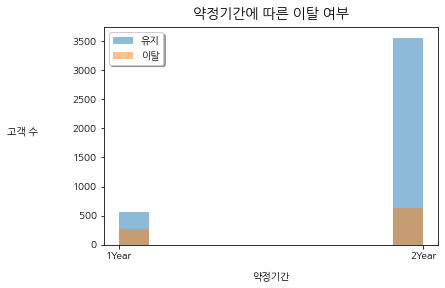

In [111]:
# 약정기간
fun_plot_hist(customer_df,'Contract')
plt.title("약정기간에 따른 이탈 여부", fontsize=14, pad=10)
plt.xlabel('약정기간',labelpad=10)
plt.ylabel('고객 수', rotation=0, labelpad=50)
plt.legend(shadow=True)

- 약정기간 2년일 때 이탈자 수가 적음
- 마케팅 시 1년보다는 2년 약정이 더 나을 것으로 기대

# 3. 모델링 및 평가
### 고객 이탈 여부 예측 모델링 및 평가와 LTV 모델 개선 필요성 확인

#### 고객 이탈여부 모델
- 이탈여부(ChurnLabel)을 알아보기때문에 분류모델 사용
- 분류 모델에 평가 지표에는 정확도, 정밀도, 재현율, F1 Score, AUC 등이 있음
- 고객 이탈에 대한 분류로 불균형한 데이터일 경우에는 정확도만으로는 올바른 평가를 할 수 없음
- 정밀도와 재현율의 수치가 조합된 F1 score로 평가하는 것이 가장 적합

In [139]:
model_df = customer_df
# model_df
model_df.replace({'Yes':1, 'No':0},inplace=True)
model_df.replace({'Male':1, 'Female':0},inplace=True)
model_df.replace({'2Year':1, '1Year':0},inplace=True)

In [114]:
model_df.columns

Index(['CustomerId', 'ContractID', 'CustomerLTV', 'ChurnScore', 'SatisScore',
       'ChurnLabel', 'Gender', 'Age', 'AgeGroup', 'Married', 'Dependents',
       'noDependents', 'Referrals', 'noReferrals', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'UnlimitedData', 'AvgDownloadGB',
       'TotalRefund', 'TotalExtraDataCharge', 'AvgLongDistanceCharge',
       'TotalLongDistanceCharge', 'StartDate', 'EndDate', 'ChurnCategory',
       'ChurnReason', 'AvgCharge', 'TotalCharge', 'TotalRevenue',
       'TenureMonths'],
      dtype='object')

In [115]:
model_y = model_df['ChurnLabel']
model_x = model_df.drop(['CustomerId','ContractID','ChurnLabel','ChurnScore','Gender','StartDate','EndDate','ChurnCategory','ChurnReason',],axis=1) # 의미없는 명목형 삭제

In [116]:
model_dummies = pd.get_dummies(model_x) # 더미변수화
model_train_x,model_test_x,model_train_y,model_test_y = train_test_split(model_dummies,model_y,
                                                            test_size = 0.3, random_state=1234) # train 70%, test 30%

print('train data X size : {}'.format(model_train_x.shape))
print('train data Y size : {}'.format(model_train_y.shape))
print('test data X size : {}'.format(model_test_x.shape))
print('test data Y size : {}'.format(model_test_y.shape))

train data X size : (3516, 34)
train data Y size : (3516,)
test data X size : (1507, 34)
test data Y size : (1507,)


In [118]:
# 모델 별 평가지표 확인
model = ['DecisionTree','RandomForest','GradientBoosting','XGB','NeuraNet','SVM'] 

train_accuracy = []
test_accuracy = []
model_f1_score = []
model_auc = []

In [119]:
# 1. DT 모델 

#모델 생성
dt_model = DecisionTreeClassifier(random_state=1234, max_depth=7, min_samples_leaf=16, min_samples_split=20)
dt_model.fit(model_train_x, model_train_y)

# train 정확도
train_accuracy.append(dt_model.score(model_train_x,model_train_y))
# test 정확도
test_accuracy.append(dt_model.score(model_test_x,model_test_y))

# 예측값
y_pred = dt_model.predict(model_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN) : 거짓 양성 비율, tpr = TP/(TP+FN) : 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(model_test_y,y_pred)
roc_auc = auc(fpr,tpr)
model_auc.append(roc_auc)

# f1 score
model_f1_score.append(f1_score(model_test_y,y_pred))

In [120]:
# 2. RF 모델

# 모델 생성
rf_model = RandomForestClassifier(random_state=1234, n_estimators=60, min_samples_leaf=1, max_depth=8,min_samples_split=31)
rf_model.fit(model_train_x,model_train_y)

# train 정확도
train_accuracy.append(rf_model.score(model_train_x,model_train_y))
# test 정확도
test_accuracy.append(rf_model.score(model_test_x,model_test_y))

# 예측값
y_pred = rf_model.predict(model_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN) : 거짓 양성 비율, tpr = TP/(TP+FN) : 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(model_test_y,y_pred)
roc_auc = auc(fpr,tpr)
model_auc.append(roc_auc)

# f1 score
model_f1_score.append(f1_score(model_test_y,y_pred))

In [121]:
# 3. GB 모델

# 모델 생성
gb_model = GradientBoostingClassifier(min_samples_leaf = 10, max_depth = 4, n_estimators = 100, learning_rate = 1, random_state = 1234)
gb_model.fit(model_train_x, model_train_y)

# train 정확도
train_accuracy.append(gb_model.score(model_train_x, model_train_y))
# test 정확도
test_accuracy.append(gb_model.score(model_test_x, model_test_y))

# 예측값
y_pred = gb_model.predict(model_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN) : 거짓 양성 비율, tpr = TP/(TP+FN) : 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(model_test_y, y_pred)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

# f1 score
model_f1_score.append(f1_score(model_test_y,y_pred))

In [122]:
# 4. XGB 모델

# 모델 생성
xgb_model = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
xgb_model.fit(model_train_x, model_train_y)

# train 정확도
train_accuracy.append(xgb_model.score(model_train_x, model_train_y))
# test 정확도
test_accuracy.append(xgb_model.score(model_test_x, model_test_y))

# 예측값
y_pred = xgb_model.predict(model_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN) : 거짓 양성 비율, tpr = TP/(TP+FN) : 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(model_test_y, y_pred)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

# f1 score
model_f1_score.append(f1_score(model_test_y,y_pred))

C:\Users\82106\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\82106\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\82106\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\82106\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [123]:
# 5. NeuralNet 모델
v_feature_name = model_train_x.columns

# StandaerScaler 적용
# DT, RF, GB, XGB 모두 트리기반의 모델이므로 별도의 데이터 정규화가 필요없음
# NeuralNet과 같이 딥러닝 모델은 scale 하는 것이 더 좋음

scaler = StandardScaler()
model_scaled = scaler.fit_transform(model_dummies)
model_scaled = pd.DataFrame(model_scaled, columns = v_feature_name)

model_train_x,model_test_x,model_train_y,model_test_y = train_test_split(model_scaled,model_y,
                                                            test_size = 0.3, random_state=1234)

# 모델 생성
nn_model = MLPClassifier(batch_size = 110, solver = 'adam', activation = 'logistic', hidden_layer_sizes = (160,160), random_state = 1234)
nn_model.fit(model_train_x,model_train_y)

# train 정확도
train_accuracy.append(nn_model.score(model_train_x,model_train_y))
# test 정확도
test_accuracy.append(nn_model.score(model_test_x,model_test_y))

# 예측값
y_pred = nn_model.predict(model_test_x)

# roc_curve(실제값, 예측값), fpr = FP/(FP+TN) : 거짓 양성 비율, tpr = TP/(TP+FN) : 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(model_test_y,y_pred)
roc_auc = auc(fpr,tpr)
model_auc.append(roc_auc)

# f1 score
model_f1_score.append(f1_score(model_test_y,y_pred))

In [126]:
# 6. SVM 모델

# StandaerScaler 적용
# DT, RF, GB, XGB 모두 트리기반의 모델이므로 별도의 데이터 정규화가 필요없음
# SVM은 거리 기반의 모델로 Scale 하는 것이 더 좋음

scaler = StandardScaler()
model_scaled = scaler.fit_transform(model_dummies)
model_scaled = pd.DataFrame(model_scaled, columns = v_feature_name)


model_train_x,model_test_x,model_train_y,model_test_y = train_test_split(model_scaled,model_y,
                                                            test_size = 0.3, random_state=1234)

# 모델 생성
svc_model = SVC(gamma = 0.01, C = 1, random_state=1234)
svc_model.fit(model_train_x, model_train_y)

train_accuracy.append(svc_model.score(model_train_x,model_train_y))

test_accuracy.append(svc_model.score(model_test_x,model_test_y))

y_pred = svc_model.predict(model_test_x)



fpr, tpr, thresholds = roc_curve(model_test_y,y_pred)
roc_auc = auc(fpr,tpr)
model_auc.append(roc_auc)

model_f1_score.append(f1_score(model_test_y,y_pred))

In [137]:
# 모델별 정확도 산출 및 평가

model_eval = pd.DataFrame(index = model)

model_eval['TrainAccuracy']= train_accuracy
model_eval['TestAccuracy']= test_accuracy

model_eval['F1Score']= model_f1_score
model_eval['AUC']= model_auc

model_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,AUC
DecisionTree,0.967,0.971,0.912,0.924
RandomForest,0.962,0.965,0.891,0.901
GradientBoosting,0.994,0.956,0.871,0.906
XGB,1.000,0.965,0.897,0.918
NeuraNet,0.970,0.969,0.910,0.929
SVM,0.961,0.963,0.884,0.896


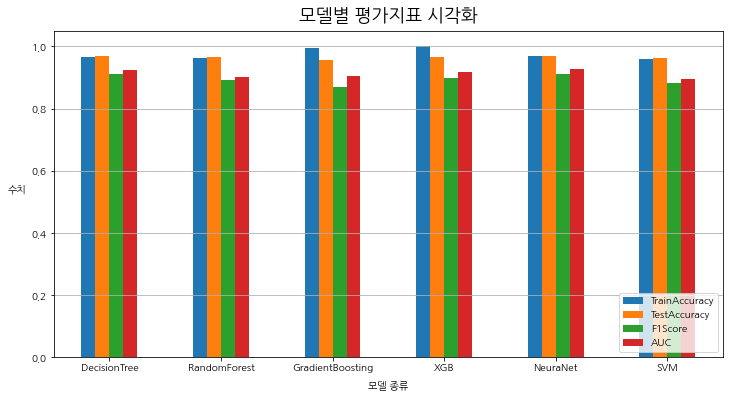

In [138]:
model_eval.plot.bar(rot=0, figsize=(12,6))
plt.title('모델별 평가지표 시각화', fontsize=18, pad=10)
plt.legend(loc = 'lower right')
plt.xlabel('모델 종류', labelpad=8)
plt.ylabel('수치', rotation=0, labelpad=15)
plt.grid(axis = 'y')

- F1 Score이 가장 높은 Neural net 모델 최종 선정
- 고객 이탈률을 잘 예측한다고 할 수 있음

#### LTV(Lifetime Value) 모델 개선 : 고객의 평생 가치, 거래 기간동안 고객에서 얻는 수익 또는 손실
- 이탈 예상 고객 중 기업에 이윤을 주는 고객을 우선 타겟팅해야함
- 신규고객 유치하는 비용보다 장기고객을 유지하는 것이 더 효율적! (신규고객 유치금액이 장기고객 유지금액의 약 5배)
- 데이터상, 인원과 데이터 사용량이 가장 많은 20~30대가 주요 타겟
- LTV 점수가 높음에도 이탈률이 높은 것은, 기존 모델의 개선이 필요하다는 것 
- 즉, 고객 특성에 맞는 LTV 모델 개선으로 정확한 고객 분류가 필요

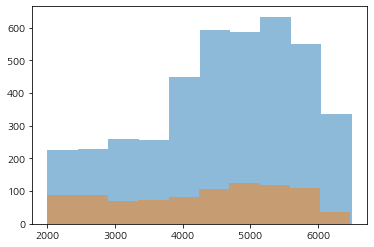

In [63]:
fun_plot_hist(customer_df,'CustomerLTV')

In [90]:
# 1. 기존의 LTV점수(변수명:CustomerLTV)를 설명하는데 어떤 변수가 가장 영향력 있었을까?
reg_model = smf.ols(formula = "CustomerLTV~ ChurnScore+SatisScore+C(Gender)+Age+C(Married)+C(Dependents)+C(Contract)+TotalRefund+TotalExtraDataCharge+AvgLongDistanceCharge+noDependents+TotalRevenue+AvgDownloadGB+TenureMonths+TotalLongDistanceCharge",data=customer_df)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:            CustomerLTV   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     91.75
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.97e-250
Time:                        21:23:17   Log-Likelihood:                -41975.
No. Observations:                5023   AIC:                         8.398e+04
Df Residuals:                    5007   BIC:                         8.409e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                3

In [142]:
# 2. 유의하지 않거나 배경 지식으로 인해 일부 변수를 제거 후 모델 재생성
# 특히나 만족도는 특정 점수에서 분류 되므로 삭제, 점수라는 Y를 설명하기에 범주형은 적합하지 않다고 판단해 삭제
# 각종 논문 분석에서, 사용형태나 구매형태에 대한 세분화는 고객 가치를 우선으로 고려해 타겟 마케팅을 실시하는 관점에서는 적당하지 않다고 함
# 하여 계약 방법, 각종 추가 서비스에 대한 세부적인 변수는 제거하였음

ltv_y = customer_df["CustomerLTV"]
ltv_x = customer_df[["ChurnScore","SatisScore","Age","noDependents","noReferrals","AvgDownloadGB","TotalRefund",
          "TotalExtraDataCharge","AvgLongDistanceCharge","TotalLongDistanceCharge","TenureMonths"]]

In [143]:
df_train_x, df_test_x,df_train_y,df_test_y = train_test_split(ltv_x,ltv_y,\
                                                             test_size=0.4, random_state=1234)
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(3013, 11)
train data Y size:(3013,)
test data X size:(2010, 11)
test data Y size:(2010,)


In [146]:
ltv_tree_uncustomized = DecisionTreeRegressor(random_state=1234)
ltv_tree_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(ltv_tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(ltv_tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: -0.477


In [147]:
train_accuracy=[]; test_accuracy=[]
para_dept = [depth for depth in range(1,11)]

for v_max_depth in para_dept:
    tree=DecisionTreeRegressor(max_depth=v_max_depth,random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_dept
df_accuracy_depth["TrainAccuracy"]=train_accuracy
df_accuracy_depth["TestAccuracy"]=test_accuracy

In [96]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.272,0.261
1,2,0.276,0.257
2,3,0.280,0.256
3,4,0.287,0.247
4,5,0.299,0.234
5,6,0.315,0.219
6,7,0.338,0.194
7,8,0.365,0.159
8,9,0.402,0.124
9,10,0.441,0.096


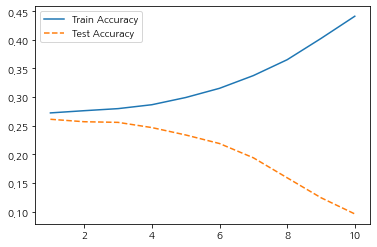

In [97]:
plt.plot(para_dept,train_accuracy,linestyle="-", label="Train Accuracy")
plt.plot(para_dept,test_accuracy,linestyle="--", label="Test Accuracy")
plt.legend()

In [98]:
v_feature_name = df_train_x.columns
tree_low = DecisionTreeRegressor(max_depth=4, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot",
               feature_names=v_feature_name,impurity=True, filled=True)


In [99]:
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_low.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

# 사용기간(TenureMonths)이 가장 중요한 Feature

,Feature,Importance
10,TenureMonths,0.953
9,TotalLongDistanceCharge,0.017
8,AvgLongDistanceCharge,0.010
5,AvgDownloadGB,0.008
0,ChurnScore,0.007
4,noReferrals,0.006
1,SatisScore,0.000
2,Age,0.000
3,noDependents,0.000
6,TotalRefund,0.000


In [100]:
# 3. 특히나 사용기간(TenureMonths)이 큰 차지를 하고 있는데 변수 하나의 설명력은 어느정도 될까?
reg_model = smf.ols(formula = "CustomerLTV~TenureMonths",data=customer_df)
reg_result = reg_model.fit()
print(reg_result.summary())

# 기존의 0.216에서 0.202로 다양한 변수를 넣은 모델과 큰 차이가 없음

                            OLS Regression Results                            
Dep. Variable:            CustomerLTV   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     1268.
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          6.68e-248
Time:                        21:23:17   Log-Likelihood:                -42019.
No. Observations:                5023   AIC:                         8.404e+04
Df Residuals:                    5021   BIC:                         8.406e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3427.2184     34.480     99.398   

array([[<AxesSubplot:title={'center':'TenureMonths'}>,
        <AxesSubplot:title={'center':'CustomerLTV'}>]], dtype=object)

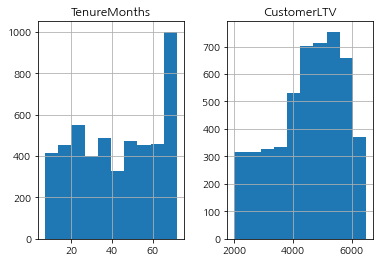

In [101]:
customer_df[["TenureMonths","CustomerLTV"]].hist()

In [105]:
# 5. LTV는 LifetimeValue로 고객의 평생가치로, 거래 기간동안 고객에서 얻는 수익이나 손실을 말함
# 위의 거래기간이 중요한 만큼 총 매출(TotalRevenue)에 영향을 줄 수 있는 변수들은 무엇일까?
reg_model = smf.ols(formula = "TotalRevenue~Age+TotalRefund+AvgLongDistanceCharge+noDependents+AvgDownloadGB+TenureMonths",data=customer_df)
reg_result = reg_model.fit()
print(reg_result.summary())

# 총 매출에 높은 설명력을 보여주는 모델로 나타남
# 나이, 총환불액, 평균장거리요금, 부양자수, 평균다운로드양, 사용기간 등으로 실제로 총매출과 연관있는 변수임

                            OLS Regression Results                            
Dep. Variable:           TotalRevenue   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     2618.
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:23:23   Log-Likelihood:                -43441.
No. Observations:                5023   AIC:                         8.690e+04
Df Residuals:                    5016   BIC:                         8.694e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3519.62

In [66]:
# 6. 위의 모델들을 참고하여 유의미한 변수였던 변수로 모델링을 해봄
reg_model1 = smf.ols(formula = "CustomerLTV~SatisScore+C(Gender)+Age+C(Married)+ noDependents+noReferrals+C(Contract)+AvgCharge+TotalRefund+TenureMonths",data=customer_df)

In [67]:
reg_result1 = reg_model1.fit()          
print(reg_result1.summary())

                            OLS Regression Results                            
Dep. Variable:            CustomerLTV   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     136.4
Date:                Wed, 06 Apr 2022   Prob (F-statistic):          4.48e-253
Time:                        00:33:04   Log-Likelihood:                -41981.
No. Observations:                5023   AIC:                         8.398e+04
Df Residuals:                    5012   BIC:                         8.405e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3521.8364 

In [69]:
# 7. 기존의 LTV점수가 현 상황을 표현하지 못한다면, 계수들을 반대로 하여서 조정하면 나오지 않을까?
# 일정 상수를 지정하여 기본 값에서 움직이도록 함
customer_df['test1'] = 100 + 0.5527 * customer_df['Age'] - 10 * customer_df['noDependents'] + 1.1639 * customer_df['TotalRefund'] + 10 * customer_df['TenureMonths'] + 0.026 * customer_df['TotalCharge']

# 나이, 부양자수, 총환불액, 사용기간, 총과금액

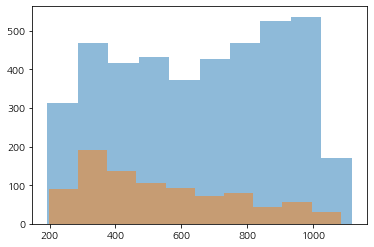

In [70]:
fun_plot_hist(customer_df,'test1')
# 기존의 LTV 점수보다 개선됨을 알 수 있음

In [71]:
# 8. 기존의 점수에서 파라미터 조정 
customer_df['test2'] = 100 + 0.5527 * customer_df['Age'] - 10 * customer_df['noDependents'] + 1.1639 * customer_df['TotalRefund'] + 15 * customer_df['TenureMonths'] + 0.026 * customer_df['TotalCharge']

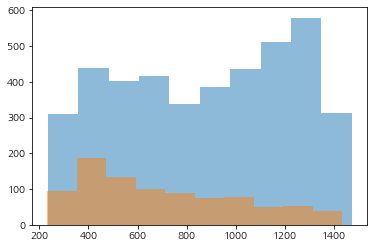

In [72]:
fun_plot_hist(customer_df,'test2')
# test1과 비슷한 모양을 보이며 위보다 순차적으로 낮아지는 모양을 보임

In [73]:
# 9. 총 매출도 좋지만 사용기간 대비 높은 비용을 사용하는 고객을 고려하기 위해 평균 과금액을 넣어봄
customer_df['test3'] = 120 - 0.236 * customer_df['Age'] - 0.08 * customer_df['TotalRefund'] + 2.28 * customer_df['noDependents'] + 0.3 * customer_df['AvgCharge'] + 1.386 * customer_df['TenureMonths']

# 나이, 총환불액, 부양자수, 평균과금액, 사용기간

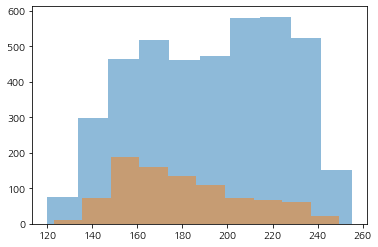

In [74]:
fun_plot_hist(customer_df,'test3')
# 위보다 개선된 분포를 보여주고 있음

In [75]:
# 10. 위의 모델 파라미터 조정했으나 기존이 나음
customer_df['test4'] = 150 - 0.36 * customer_df['Age'] - 0.08 * customer_df['TotalRefund'] + 2.28 * customer_df['noDependents'] + 0.4 * customer_df['AvgCharge'] + 1.386 * customer_df['TenureMonths']

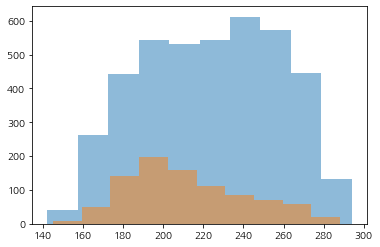

In [77]:
fun_plot_hist(customer_df,'test4')

- 최종 모델 : LTV점수 = 120 - 0.236 * 연령 - 0.08 * 총환불액 + 2.28 * 부양자수 + 0.3 * 평균 과금액 + 1.386 * 사용기간
- 연령 : 연령대가 높아질 수록 이탈 확률이 높기때문에 LTV 점수 하락 요인
- 총환불액 : 기간동안 고객에게 환불해주는 비용으로 LTV 점수 하락 요인
- 부양자 수 : 기존의 탐색적 분석에서 부양자 수가 높아질 수록 이탈률이 낮았기 때문에 LTV 점수 상승 요인
- 평균 과금액 : 기간동안 얻어진 수익에 대한 평균 비용이므로 LTV 점수 상승 요인
- 사용 기간 : 평생 가치에 가장 밀접한 관계로 LTV 점수 상승 요인

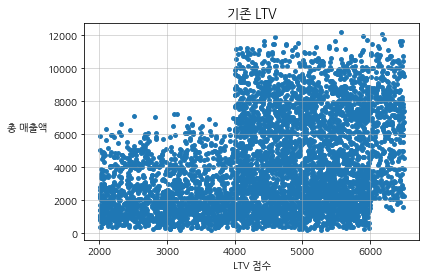

In [78]:
# 기존 LTV 점수와 총매출의 관계
plt.scatter('CustomerLTV','TotalRevenue',data=customer_df, s=15)
plt.title('기존 LTV', fontsize=13)
plt.xlabel('LTV 점수')
plt.ylabel('총 매출액', rotation='horizontal', labelpad = 20)
plt.grid(alpha=0.6)

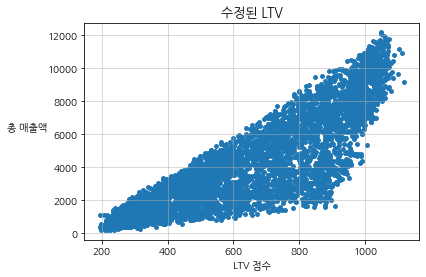

In [79]:
# 개선된 LTV 점수는 총매출액에 비례하여 설명함
plt.scatter('test1','TotalRevenue',data=customer_df, s=15)
plt.title('수정된 LTV', fontsize=13)
plt.xlabel('LTV 점수')
plt.ylabel('총 매출액', rotation='horizontal', labelpad = 20)
plt.grid(alpha=0.6)


# 편차가 감소하여 설명력이 증가 됨을 알 수 있음